Loading data for QQQ from QQQ_historical_data_fully_adjusted.csv...

Starting analysis for Investment Period: 1 Years (12 Months)
Rolling comparison from 1999-04 to 2024-07.

--- Comprehensive Performance Statistics for 1 Years ---

--- Mean Values ---
DCA_Final_Total_Asset_Value   : $1,283
LumpSum_Final_Total_Asset_Value: $1,351
DCA_Return_Pct                : 6.90%
LumpSum_Return_Pct            : 12.58%
DCA_Sharpe_Ratio              : 0.66%
LumpSum_Sharpe_Ratio          : 0.73%
DCA_Max_Drawdown_Pct          : -13.08%
LumpSum_Max_Drawdown_Pct      : -20.69%

--- Win Rate Comparison ---
DCA Wins: 83 times (27.30%)
Lump Sum Wins: 221 times (72.70%)

Performance chart saved to: QQQ_DCA_vs_LumpSum_Rolling_Returns_Comparison_1Y_TotalAsset.png

Starting analysis for Investment Period: 2 Years (24 Months)
Rolling comparison from 1999-04 to 2023-07.

--- Comprehensive Performance Statistics for 2 Years ---

--- Mean Values ---
DCA_Final_Total_Asset_Value   : $2,738
LumpSum_Final_Total_Asset_V

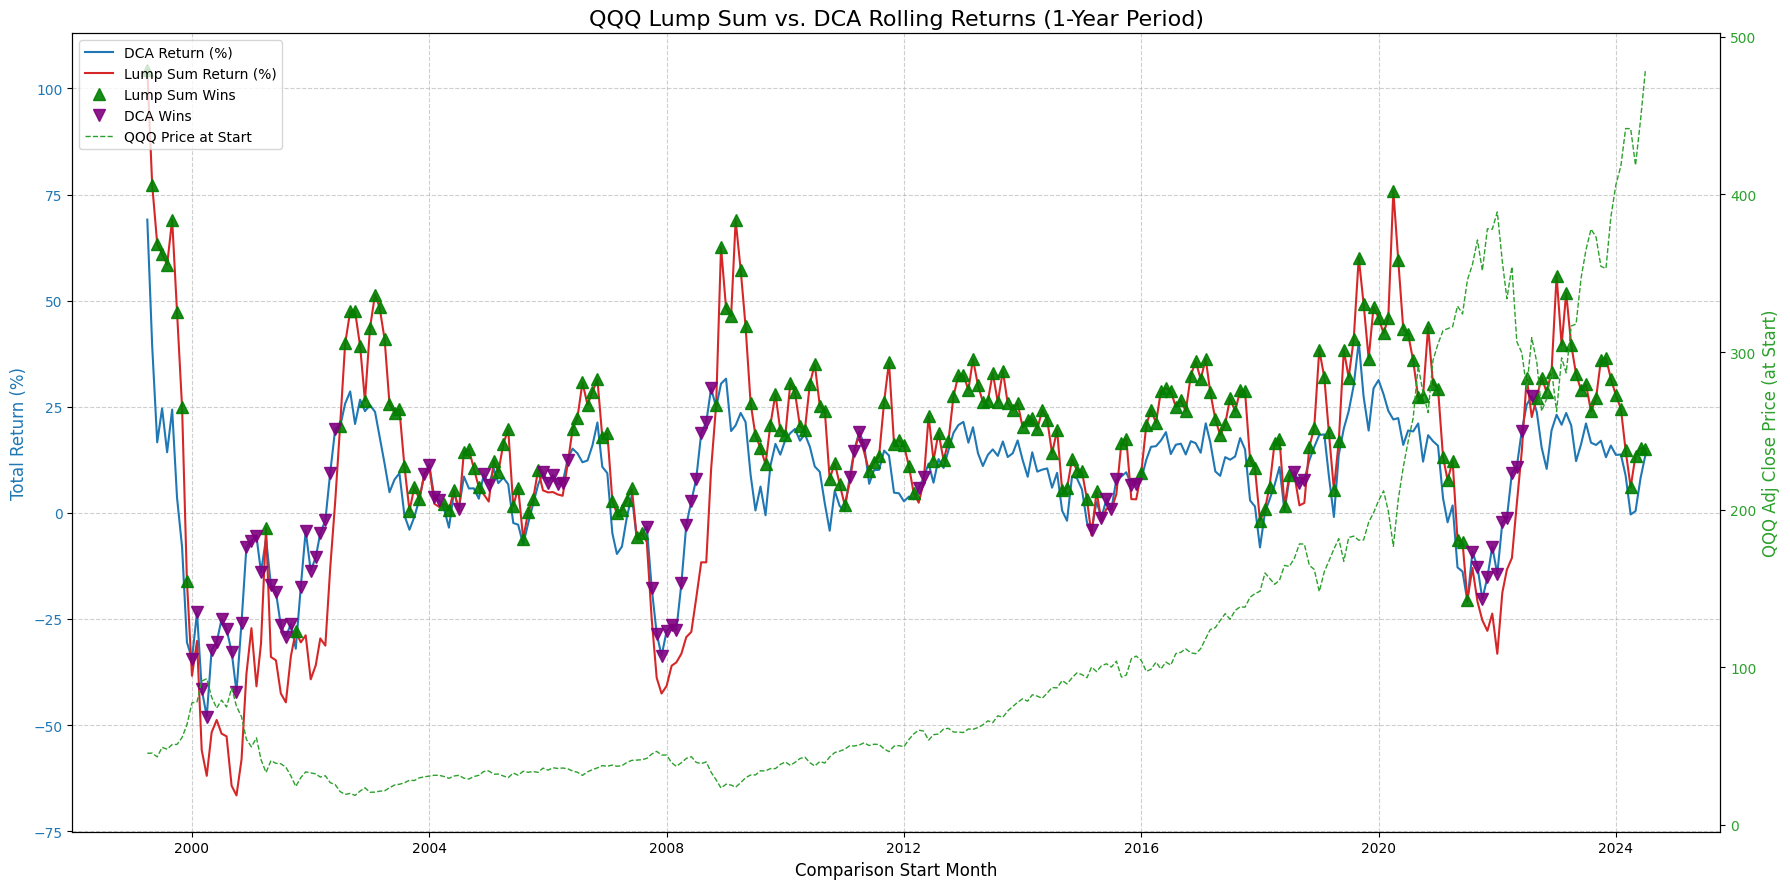

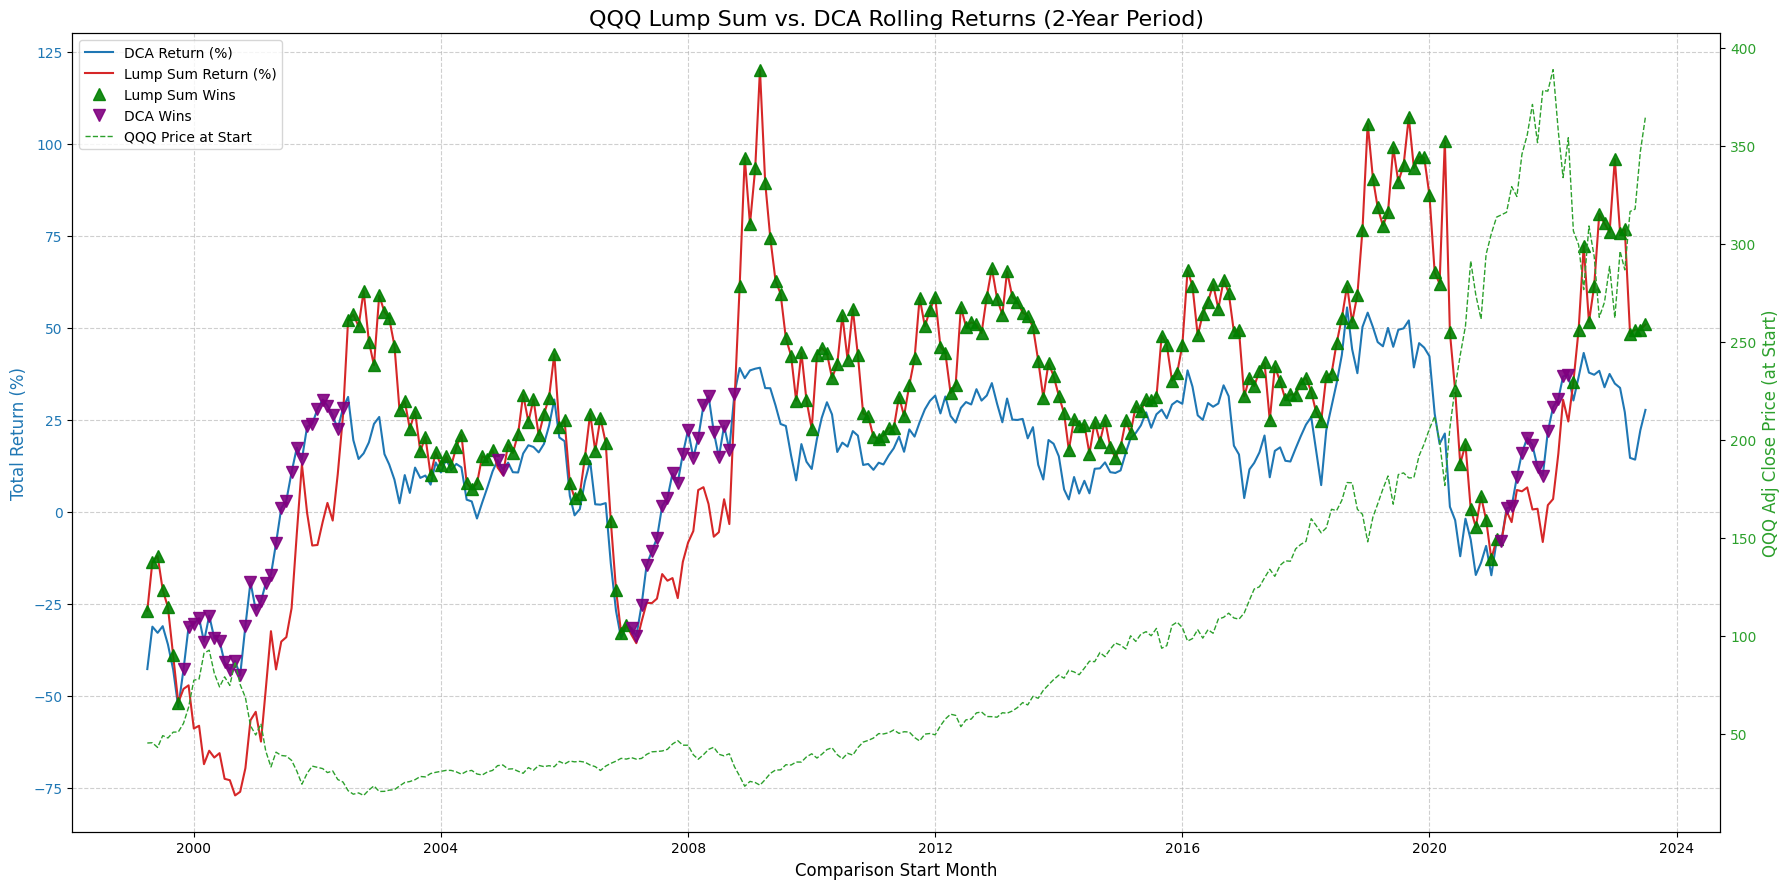

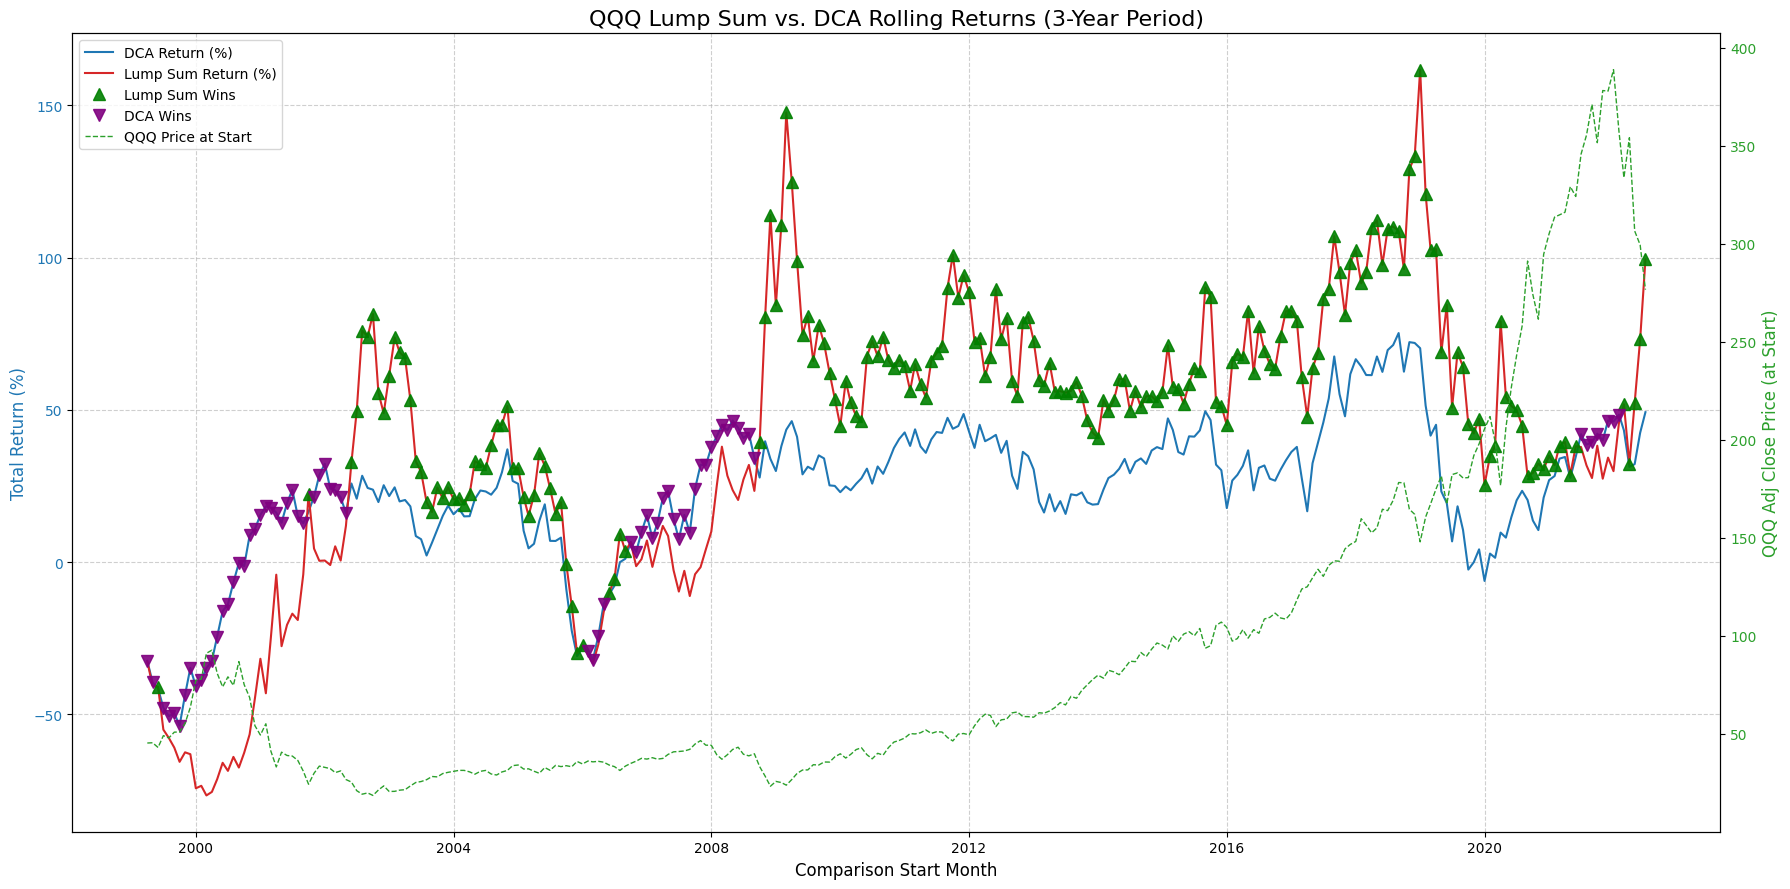

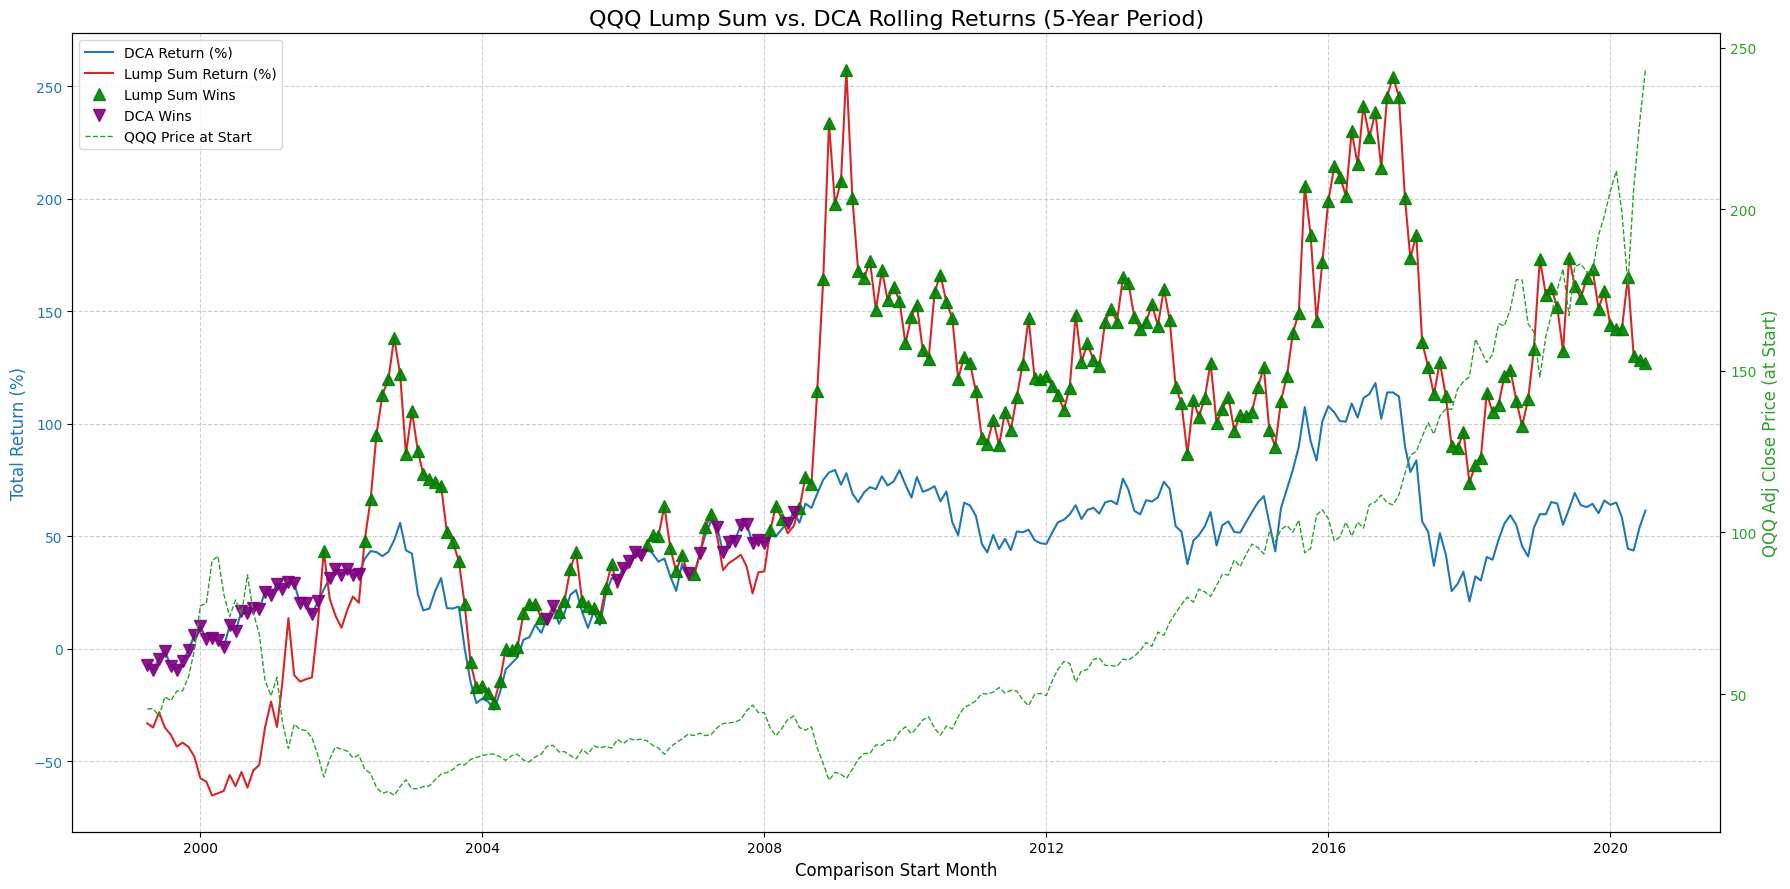

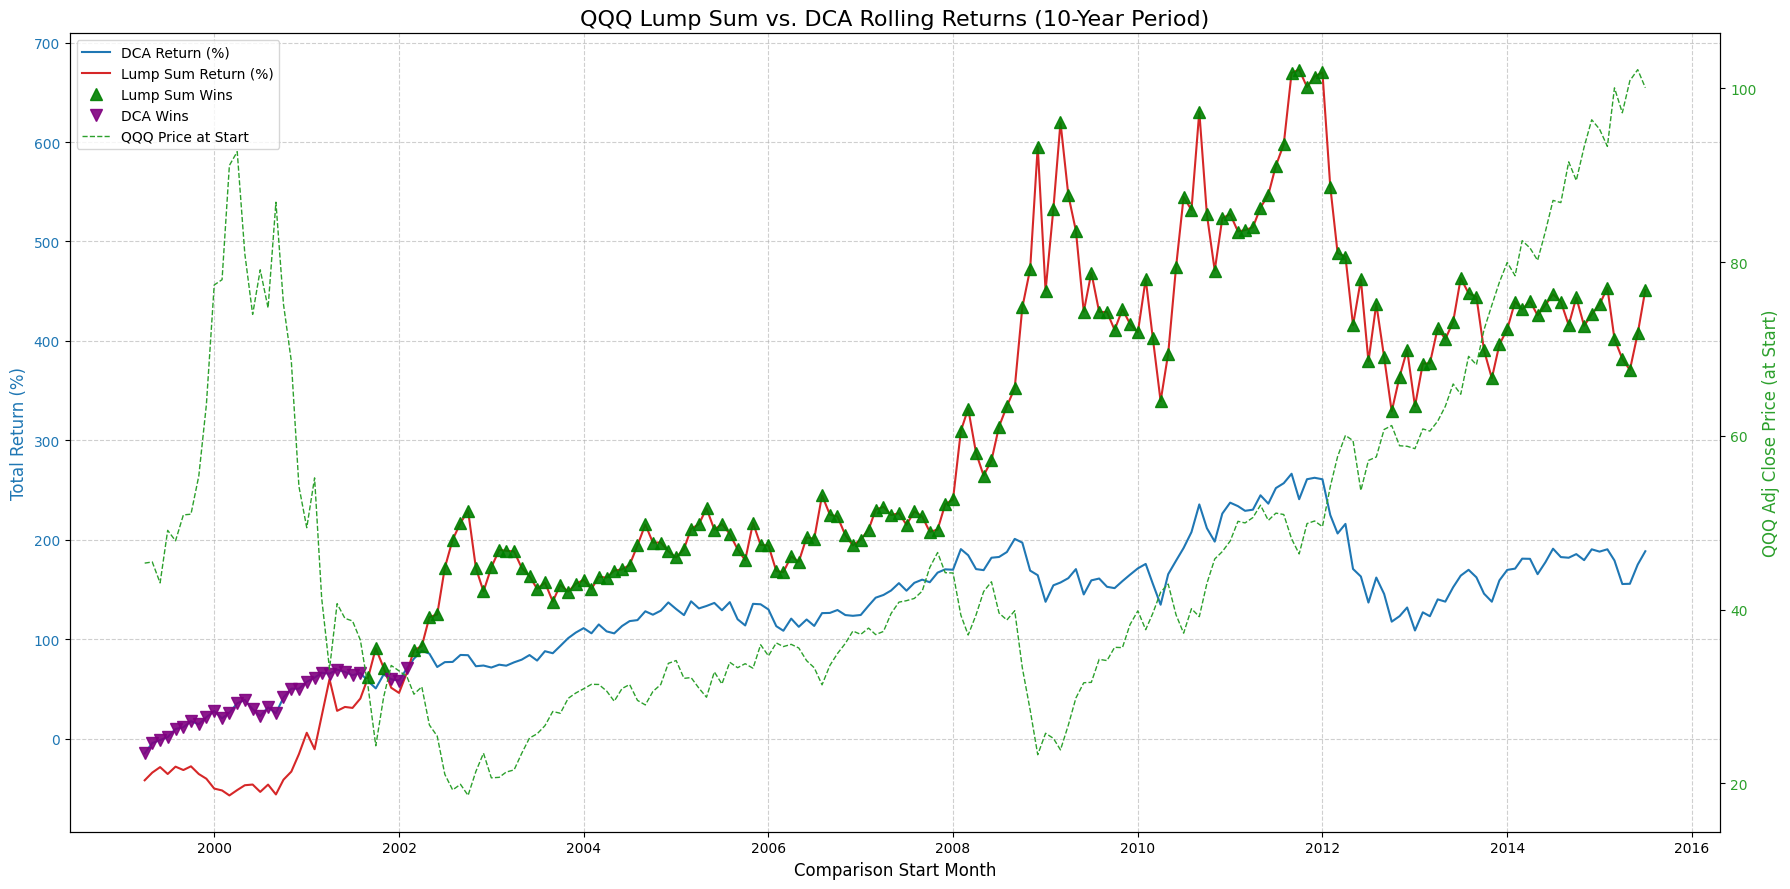

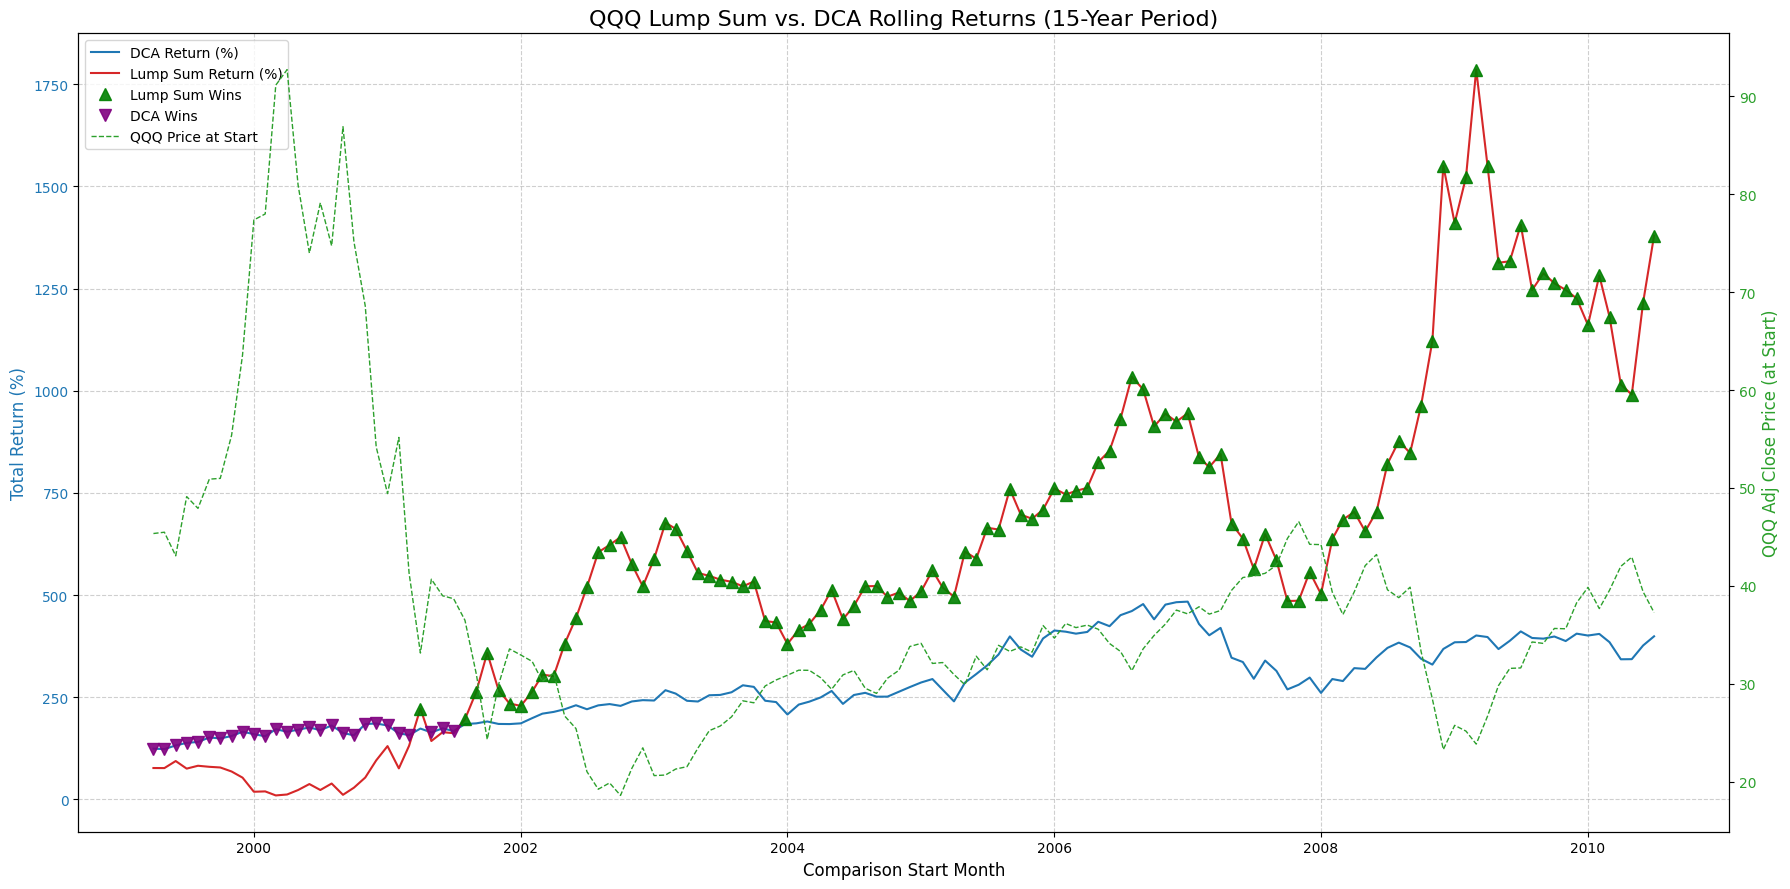

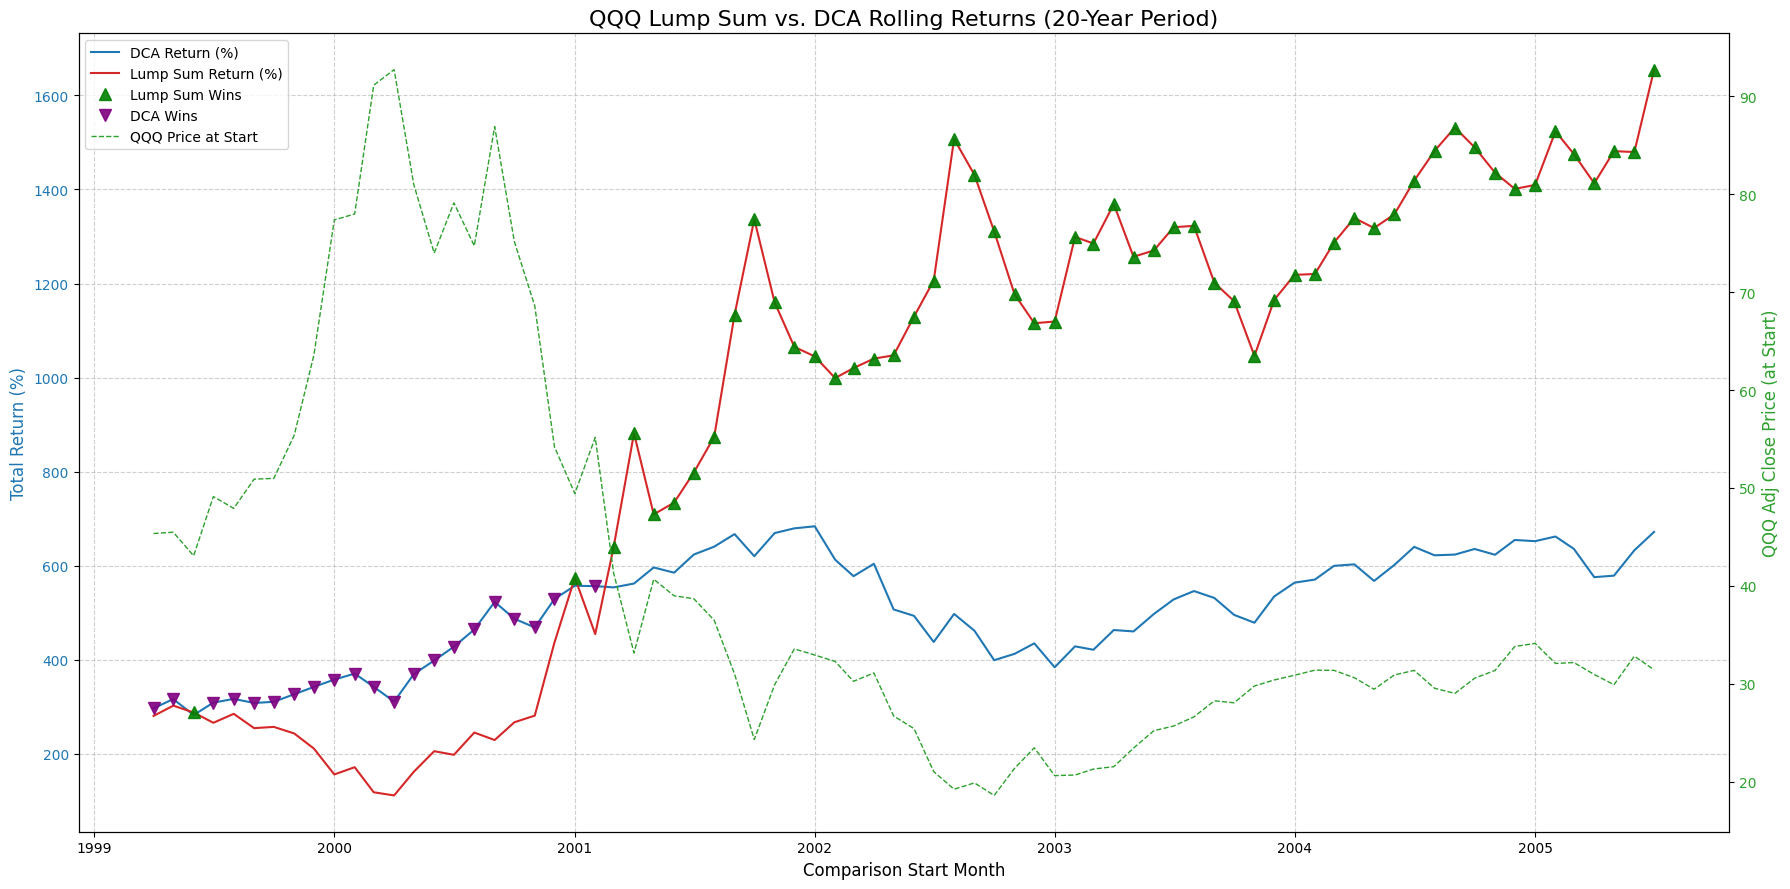

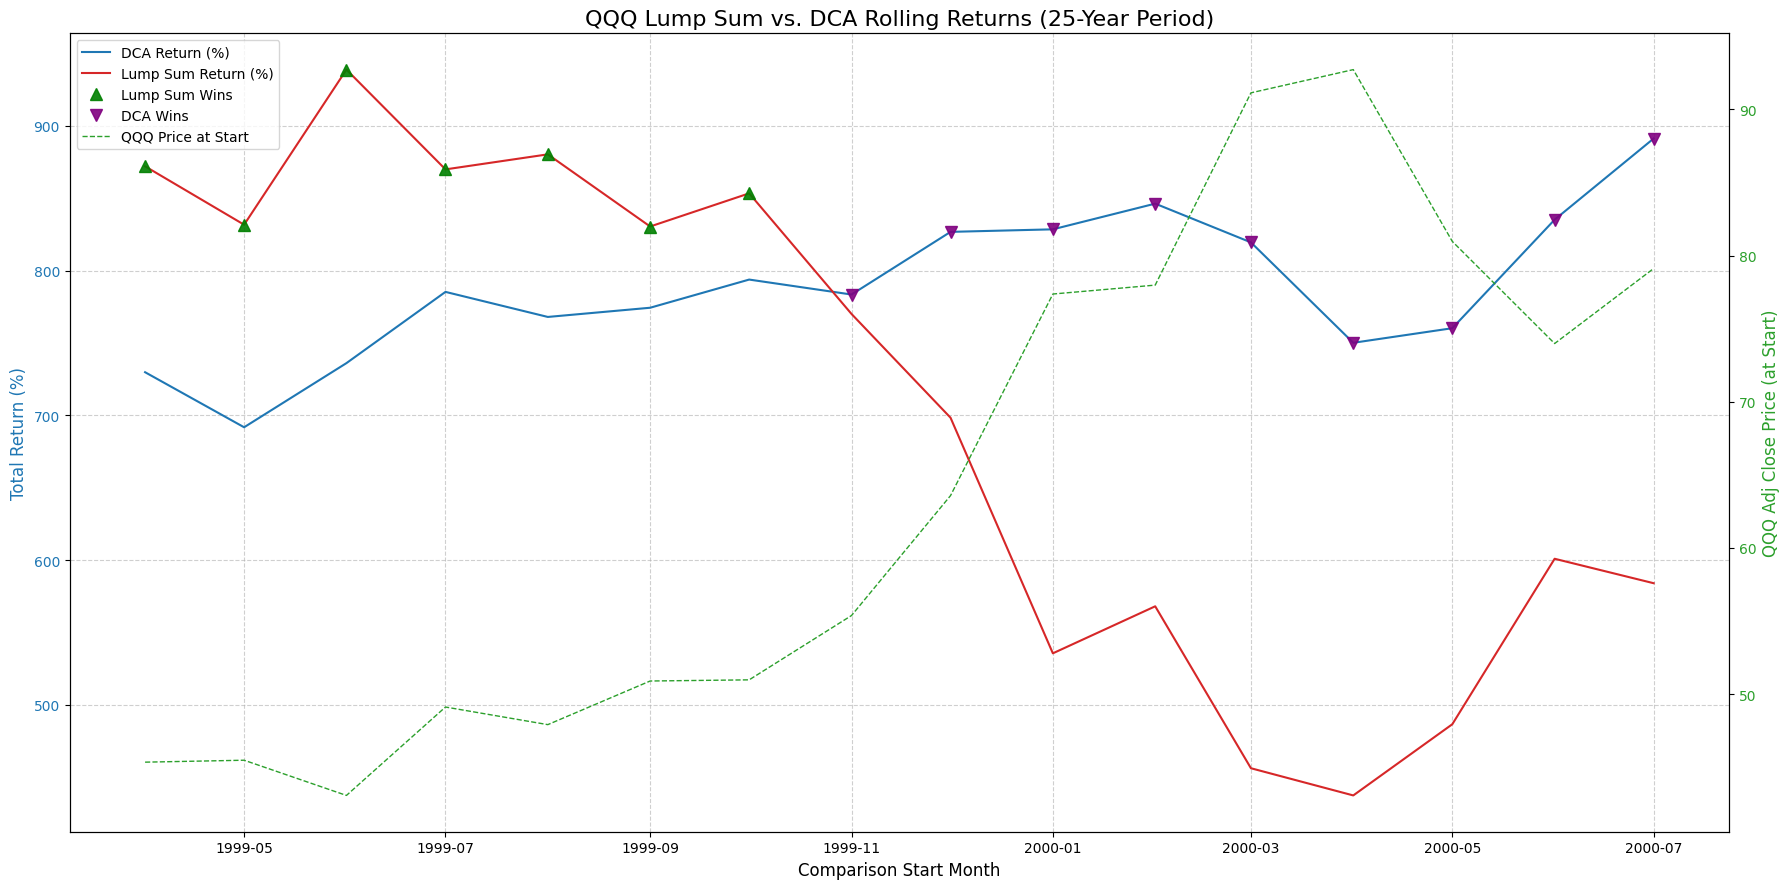

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- 1. 主要參數修改 ---
ticker = "QQQ"  # 改為分析 QQQ
adjusted_data_file = f"{ticker}_historical_data_fully_adjusted.csv"
monthly_investment_amount = 100  # 注意：單位現在是美元 (USD)
risk_free_rate_annual = 0.015  # Annual risk-free rate (1.5%)
trading_days_per_year = 252  # Assumed trading days per year

# Define a single output CSV file for all results
total_output_csv_file = f"{ticker}_DCA_vs_LumpSum_All_Periods_Comparison_TotalAsset.csv"

print(f"Loading data for {ticker} from {adjusted_data_file}...")

if not os.path.exists(adjusted_data_file):
    print(f"Error: File '{adjusted_data_file}' not found.")
    exit()

# --- 2. 資料讀取邏輯修改 ---
# 根據圖片中的格式，header在第一行(0)，真實資料從第四行開始，因此跳過第2, 3行(索引1, 2)
# 並將第一欄作為索引欄
try:
    df = pd.read_csv(adjusted_data_file, header=0, skiprows=[1, 2], index_col=0)
    # 將索引轉換為日期時間格式
    df.index = pd.to_datetime(df.index)
    # 將索引的名稱統一為 'Date'
    df.index.name = 'Date'
except Exception as e:
    print(f"Error reading or parsing the CSV file: {e}")
    print("Please ensure the file format matches the expected structure.")
    exit()
    
df = df.sort_index()

if "Adj Close" not in df.columns:
    print("Error: 'Adj Close' column missing from data. Please check the data source.")
    exit()
df["Adj Close"] = pd.to_numeric(df["Adj Close"], errors="coerce")
df.dropna(subset=["Adj Close"], inplace=True)


# --- Helper Function: Calculate Portfolio Metrics (No changes needed here) ---
def calculate_portfolio_metrics(
    portfolio_values, total_invested_amount, risk_free_rate_daily
):
    if (
        portfolio_values.empty
        or pd.isna(total_invested_amount)
        or total_invested_amount <= 0
    ):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    final_value = portfolio_values.iloc[-1]
    total_return_percentage = (
        (final_value - total_invested_amount) / total_invested_amount
    ) * 100
    daily_returns = portfolio_values.pct_change().dropna()
    if daily_returns.empty or daily_returns.std() == 0:
        return final_value, total_return_percentage, np.nan, np.nan, np.nan, np.nan
    excess_returns = daily_returns - risk_free_rate_daily
    sharpe_ratio = np.sqrt(trading_days_per_year) * (
        excess_returns.mean() / excess_returns.std()
    )
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    max_drawdown = drawdown.min() * 100
    downside_returns = excess_returns[excess_returns < 0]
    if downside_returns.empty or downside_returns.std() == 0:
        sortino_ratio = np.nan
    else:
        sortino_ratio = np.sqrt(trading_days_per_year) * (
            excess_returns.mean() / downside_returns.std()
        )
    num_years = (
        portfolio_values.index.max() - portfolio_values.index.min()
    ).days / 365.25
    if num_years <= 0 or np.isnan(total_return_percentage):
        annualized_return_for_calmar = np.nan
    else:
        annualized_return_for_calmar = (
            (1 + total_return_percentage / 100) ** (1 / num_years) - 1
            if (1 + total_return_percentage / 100) >= 0
            else np.nan
        )
    if max_drawdown == 0 or np.isnan(annualized_return_for_calmar) or max_drawdown >= 0:
        calmar_ratio = np.nan
    else:
        calmar_ratio = annualized_return_for_calmar / abs(max_drawdown / 100)
    return (
        final_value,
        total_return_percentage,
        sharpe_ratio,
        max_drawdown,
        sortino_ratio,
        calmar_ratio,
    )


# --- Main Analysis Section ---
investment_periods_years = [1, 2, 3, 5, 10, 15, 20, 25] # 調整測試年期
investment_periods_months_list = [y * 12 for y in investment_periods_years]
all_periods_results = []
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / trading_days_per_year) - 1

for investment_period_months in investment_periods_months_list:
    current_investment_years = investment_period_months // 12
    lump_sum_investment_amount = monthly_investment_amount * investment_period_months

    print(f"\n{'='*50}")
    print(
        f"Starting analysis for Investment Period: {current_investment_years} Years ({investment_period_months} Months)"
    )
    print(f"{'='*50}")

    output_plot_file = f"{ticker}_DCA_vs_LumpSum_Rolling_Returns_Comparison_{current_investment_years}Y_TotalAsset.png"
    all_results_for_this_period = []

    # --- 3. 分析起始日修改 ---
    start_date_range = pd.date_range(
        start="1999-03-10", # 將分析起點提早
        end=df.index.max() - pd.DateOffset(months=investment_period_months),
        freq="MS",
    )

    if start_date_range.empty:
        print("Not enough data to perform analysis for this period. Skipping.")
        continue

    print(
        f"Rolling comparison from {start_date_range[0].strftime('%Y-%m')} to {start_date_range[-1].strftime('%Y-%m')}."
    )

    for start_date_investment_period in start_date_range:
        end_date_investment_period = (
            start_date_investment_period
            + pd.DateOffset(months=investment_period_months)
            - pd.Timedelta(days=1)
        )
        if end_date_investment_period > df.index.max():
            continue

        # --- Lump Sum (Already efficient) ---
        lump_sum_data_period = df.loc[
            start_date_investment_period:end_date_investment_period
        ]
        if lump_sum_data_period.empty:
            continue
        lump_sum_initial_price_date = lump_sum_data_period.index.min()
        lump_sum_initial_price = lump_sum_data_period.at[
            lump_sum_initial_price_date, "Adj Close"
        ]
        if pd.isna(lump_sum_initial_price) or lump_sum_initial_price <= 0:
            continue
        lump_sum_shares = lump_sum_investment_amount / lump_sum_initial_price
        lump_sum_portfolio_values = lump_sum_data_period["Adj Close"] * lump_sum_shares
        ls_final_value, ls_return_pct, ls_sharpe, ls_max_dd, ls_sortino, ls_calmar = (
            calculate_portfolio_metrics(
                lump_sum_portfolio_values,
                lump_sum_investment_amount,
                risk_free_rate_daily,
            )
        )

        # --- OPTIMIZED: Dollar-Cost Averaging (DCA) Section ---
        dca_period_data = df.loc[
            start_date_investment_period:end_date_investment_period
        ]

        investment_month_starts = pd.date_range(
            start=start_date_investment_period,
            periods=investment_period_months,
            freq="MS",
        )
        indexer = df.index.get_indexer(investment_month_starts, method="bfill")
        valid_indexer = indexer[indexer != -1]
        investment_dates_set = set(df.index[valid_indexer])
        
        (
            dc_final_total_asset, dc_return_pct, dc_sharpe,
            dc_max_dd, dc_sortino, dc_calmar,
        ) = (np.nan,) * 6

        if not dca_period_data.empty:
            adj_close_array = dca_period_data["Adj Close"].to_numpy(dtype=np.float64)
            dates_array = dca_period_data.index.to_numpy()
            num_days = len(dates_array)

            cash_value_array = np.zeros(num_days, dtype=np.float64)
            shares_held_array = np.zeros(num_days, dtype=np.float64)

            cash = float(lump_sum_investment_amount)
            shares = 0.0

            for i in range(num_days):
                if i > 0:
                    cash = cash_value_array[i - 1] * (1 + risk_free_rate_daily)
                    shares = shares_held_array[i - 1]

                if dates_array[i] in investment_dates_set:
                    price = adj_close_array[i]
                    if (
                        not np.isnan(price)
                        and price > 0
                        and cash >= monthly_investment_amount
                    ):
                        shares += monthly_investment_amount / price
                        cash -= monthly_investment_amount

                cash_value_array[i] = cash
                shares_held_array[i] = shares

            stock_value_array = shares_held_array * adj_close_array
            total_asset_value_array = stock_value_array + cash_value_array

            dca_total_asset_values = pd.Series(
                total_asset_value_array, index=dca_period_data.index
            )

            if not dca_total_asset_values.empty:
                (
                    dc_final_total_asset, dc_return_pct, dc_sharpe,
                    dc_max_dd, dc_sortino, dc_calmar,
                ) = calculate_portfolio_metrics(
                    dca_total_asset_values,
                    lump_sum_investment_amount,
                    risk_free_rate_daily,
                )

        # --- Store results ---
        result_row = {
            "Investment_Period_Years": current_investment_years, "Comparison_Start_Month": start_date_investment_period.strftime("%Y-%m"), "Comparison_End_Month": end_date_investment_period.strftime("%Y-%m"),
            "DCA_Final_Total_Asset_Value": dc_final_total_asset, "LumpSum_Final_Total_Asset_Value": ls_final_value, "Total_Initial_Capital": lump_sum_investment_amount,
            "DCA_Return_Pct": dc_return_pct, "DCA_Sharpe_Ratio": dc_sharpe, "DCA_Max_Drawdown_Pct": dc_max_dd, "DCA_Sortino_Ratio": dc_sortino, "DCA_Calmar_Ratio": dc_calmar,
            "LumpSum_Return_Pct": ls_return_pct, "LumpSum_Sharpe_Ratio": ls_sharpe, "LumpSum_Max_Drawdown_Pct": ls_max_dd, "LumpSum_Sortino_Ratio": ls_sortino, "LumpSum_Calmar_Ratio": ls_calmar,
            "DCA_Outperforms_LumpSum_Return": 1 if pd.notna(dc_return_pct) and pd.notna(ls_return_pct) and dc_return_pct > ls_return_pct else 0,
            "LumpSum_Outperforms_DCA_Return": 1 if pd.notna(dc_return_pct) and pd.notna(ls_return_pct) and ls_return_pct > dc_return_pct else 0,
        }
        all_periods_results.append(result_row)
        all_results_for_this_period.append(result_row)

    results_df_current_period = pd.DataFrame(all_results_for_this_period)

    # --- Statistics and Plotting ---
    if not results_df_current_period.empty:
        print(f"\n--- Comprehensive Performance Statistics for {current_investment_years} Years ---")
        comparison_metrics = ["DCA_Final_Total_Asset_Value", "LumpSum_Final_Total_Asset_Value", "DCA_Return_Pct", "LumpSum_Return_Pct", "DCA_Sharpe_Ratio", "LumpSum_Sharpe_Ratio", "DCA_Max_Drawdown_Pct", "LumpSum_Max_Drawdown_Pct"]
        mean_values = results_df_current_period[comparison_metrics].mean()
        print("\n--- Mean Values ---")
        for metric, value in mean_values.items():
            print(f"{metric:<30}: ${value:,.0f}" if "Value" in metric else f"{metric:<30}: {value:.2f}%")
        
        # Win Rate Calculation
        dca_wins = results_df_current_period["DCA_Outperforms_LumpSum_Return"].sum()
        lump_sum_wins = results_df_current_period["LumpSum_Outperforms_DCA_Return"].sum()
        total_valid = dca_wins + lump_sum_wins
        if total_valid > 0:
            print("\n--- Win Rate Comparison ---")
            print(f"DCA Wins: {dca_wins} times ({dca_wins/total_valid:.2%})")
            print(f"Lump Sum Wins: {lump_sum_wins} times ({lump_sum_wins/total_valid:.2%})")


        # Plotting
        results_df_current_period["Comparison_Start_Date"] = pd.to_datetime(results_df_current_period["Comparison_Start_Month"])
        
        fig, ax1 = plt.subplots(figsize=(18, 9))
        ax1.set_xlabel("Comparison Start Month", fontsize=12)
        ax1.set_ylabel("Total Return (%)", color="tab:blue", fontsize=12)
        ax1.plot(results_df_current_period["Comparison_Start_Date"], results_df_current_period["DCA_Return_Pct"], label="DCA Return (%)", color="tab:blue", linewidth=1.5)
        ax1.plot(results_df_current_period["Comparison_Start_Date"], results_df_current_period["LumpSum_Return_Pct"], label="Lump Sum Return (%)", color="tab:red", linewidth=1.5)
        ax1.tick_params(axis="y", labelcolor="tab:blue")
        ax1.grid(True, linestyle="--", alpha=0.6)
        
        lump_sum_wins_plot = results_df_current_period.loc[(results_df_current_period['LumpSum_Outperforms_DCA_Return'] == 1) & (pd.notna(results_df_current_period['LumpSum_Return_Pct']))]
        ax1.plot(lump_sum_wins_plot['Comparison_Start_Date'], lump_sum_wins_plot['LumpSum_Return_Pct'], '^', markersize=9, color='green', alpha=0.9, label='Lump Sum Wins', linestyle='None')
        dca_wins_plot = results_df_current_period.loc[(results_df_current_period['DCA_Outperforms_LumpSum_Return'] == 1) & (pd.notna(results_df_current_period['DCA_Return_Pct']))]
        ax1.plot(dca_wins_plot['Comparison_Start_Date'], dca_wins_plot['DCA_Return_Pct'], 'v', markersize=9, color='purple', alpha=0.9, label='DCA Wins', linestyle='None')

        ax2 = ax1.twinx()
        ax2.set_ylabel(f"{ticker} Adj Close Price (at Start)", color="tab:green", fontsize=12)
        start_dates = results_df_current_period["Comparison_Start_Date"]
        prices_at_start = df["Adj Close"].reindex(start_dates, method="ffill").values
        ax2.plot(start_dates, prices_at_start, color="tab:green", linestyle="--", linewidth=1.0, label=f"{ticker} Price at Start")
        ax2.tick_params(axis="y", labelcolor="tab:green")

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=10)
        
        plt.title(f"{ticker} Lump Sum vs. DCA Rolling Returns ({current_investment_years}-Year Period)", fontsize=16)
        fig.tight_layout()
        plt.savefig(output_plot_file, dpi=300, bbox_inches="tight")
        print(f"\nPerformance chart saved to: {output_plot_file}")

# --- Final CSV Output ---
if all_periods_results:
    final_results_df = pd.DataFrame(all_periods_results)
    final_results_df.to_csv(total_output_csv_file, index=False, encoding="utf-8-sig")
    print(f"\nAll results consolidated into: {total_output_csv_file}")
else:
    print("\nNo results were generated for any investment period.")

print("\n--- All analyses completed ---")